<a href="https://colab.research.google.com/github/firenzeey/Visual-Question-Answering-with-Multimodal-Learning/blob/main/VQA_multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual Question Answering using Multimodal Transformer Models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 19.3 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 96.6 MB/s eta 0:00:00


## Import necessary libraries & set up the environment

In [ ]:
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from transformers import (
    AutoTokenizer, AutoFeatureExtractor,
    AutoModel,
    TrainingArguments, Trainer,
    # Misc
    logging
)

# import nltk
# nltk.download('wordnet')
from nltk.corpus import wordnet

from sklearn.metrics import accuracy_score, f1_score

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

cuda:0
Tesla T4


## Load the dataset

In [ ]:
dataset = load_dataset(
    "csv",
    data_files={
        "train":"/content/drive/MyDrive/dataset/data_train.csv",
        "test": "/content/drive/MyDrive/dataset/data_test.csv"
    }
)

with open("/content/drive/MyDrive/dataset/answer_space.txt") as f:
    answer_space = f.read().splitlines()

dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0]) # Select the 1st answer if multiple answers are provided
            for ans in examples['answer']
        ]
    },
    batched=True
)

dataset

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-ae7a33d85395a439/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 9974
    })
    test: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 1999
    })
})

In [ ]:
len(np.unique(dataset['train']['label']))

525

### some of the Question/Image/Answer combinations

In [ ]:
from IPython.display import display

def showExample(train=True, id=None):
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]
    if id == None:
        id = np.random.randint(len(data))
    image = Image.open(os.path.join("..","input","/content/drive/MyDrive","dataset", "images", data[id]["image_id"] + ".png"))
    display(image)

    print("Question:\t", data[id]["question"])
    print("Answer:\t\t", data[id]["answer"], "(Label: {0})".format(data[id]["label"]))

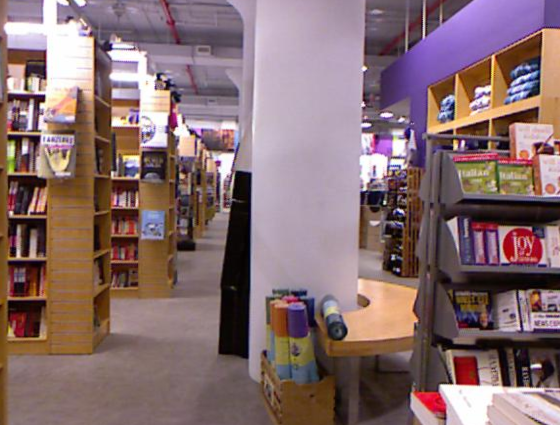

Question:	 what is on the right side of the pillar
Answer:		 table (Label: 483)


In [ ]:
showExample()

### Create a Multimodal Collator for the Dataset

In [ ]:
@dataclass
class MultimodalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor

    def tokenize_text(self, texts: List[str]):
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }

    def preprocess_images(self, images: List[str]):
        processed_images = self.preprocessor(
            images=[Image.open(os.path.join("..","input","/content/drive/MyDrive","dataset", "images", image_id + ".png")).convert('RGB') for image_id in images],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        }

    def __call__(self, raw_batch_dict):
        return {
            **self.tokenize_text(
                raw_batch_dict['question']
                if isinstance(raw_batch_dict, dict) else
                [i['question'] for i in raw_batch_dict]
            ),
            **self.preprocess_images(
                raw_batch_dict['image_id']
                if isinstance(raw_batch_dict, dict) else
                [i['image_id'] for i in raw_batch_dict]
            ),
            'labels': torch.tensor(
                raw_batch_dict['label']
                if isinstance(raw_batch_dict, dict) else
                [i['label'] for i in raw_batch_dict],
                dtype=torch.int64
            ),
        }

## Defining the Multimodal VQA Model Architecture

In [ ]:
class MultimodalVQAModel(nn.Module):
    def __init__(
            self,
            num_labels: int = len(answer_space),
            intermediate_dim: int = 512,
            pretrained_text_name: str = 'bert-base-uncased',
            pretrained_image_name: str = 'google/vit-base-patch16-224-in21k'):

        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name

        self.text_encoder = AutoModel.from_pretrained(
            self.pretrained_text_name,
        )
        self.image_encoder = AutoModel.from_pretrained(
            self.pretrained_image_name,
        )
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

        self.classifier = nn.Linear(intermediate_dim, self.num_labels)

        self.criterion = nn.CrossEntropyLoss()

    def forward(
            self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):

        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )
        logits = self.classifier(fused_output)

        out = {
            "logits": logits
        }
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss

        return out

### Define a Function to Create the Multimodal VQA Models along with their Collators

In [ ]:
def createMultimodalVQACollatorAndModel(text='bert-base-uncased', image='google/vit-base-patch16-224-in21k'):
    tokenizer = AutoTokenizer.from_pretrained(text)
    preprocessor = AutoFeatureExtractor.from_pretrained(image)

    multi_collator = MultimodalCollator(
        tokenizer=tokenizer,
        preprocessor=preprocessor,
    )


    multi_model = MultimodalVQAModel(pretrained_text_name=text, pretrained_image_name=image).to(device)
    return multi_collator, multi_model

## Performance Metrics from Visual Question Answering

### Wu and Palmer Similarity



WUP similarity works for single-word answers but doesn't work for phrases or sentences.

`nltk` has an implementation of Wu & Palmer similarity score based on the WordNet taxanomy.

In [ ]:
def wup_measure(a,b,similarity_threshold=0.925):
    """
    Returns Wu-Palmer similarity score.
    More specifically, it computes:
        max_{x \in interp(a)} max_{y \in interp(b)} wup(x,y)
        where interp is a 'interpretation field'
    """
    def get_semantic_field(a):
        weight = 1.0
        semantic_field = wordnet.synsets(a,pos=wordnet.NOUN)
        return (semantic_field,weight)


    def get_stem_word(a):
        """
        Sometimes answer has form word\d+:wordid.
        If so we return word and downweight
        """
        weight = 1.0
        return (a,weight)


    global_weight=1.0

    (a,global_weight_a)=get_stem_word(a)
    (b,global_weight_b)=get_stem_word(b)
    global_weight = min(global_weight_a,global_weight_b)

    if a==b:
        # they are the same
        return 1.0*global_weight

    if a==[] or b==[]:
        return 0


    interp_a,weight_a = get_semantic_field(a)
    interp_b,weight_b = get_semantic_field(b)

    if interp_a == [] or interp_b == []:
        return 0

    # we take the most optimistic interpretation
    global_max=0.0
    for x in interp_a:
        for y in interp_b:
            local_score=x.wup_similarity(y)
            if local_score > global_max:
                global_max=local_score

    # we need to use the semantic fields and therefore we downweight
    # unless the score is high which indicates both are synonyms
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0

    final_score=global_max*weight_a*weight_b*interp_weight*global_weight
    return final_score

In [ ]:
def batch_wup_measure(labels, preds):
    wup_scores = [wup_measure(answer_space[label], answer_space[pred]) for label, pred in zip(labels, preds)]
    return np.mean(wup_scores)

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    logits, labels = eval_tuple
    preds = logits.argmax(axis=-1)
    return {
        "wups": batch_wup_measure(labels, preds),
        "acc": accuracy_score(labels, preds)
    }

## Model Training & Evaluation

### Define the Arguments needed for Training

In [ ]:
args = TrainingArguments(
    output_dir="checkpoint",
    seed=12345,
    evaluation_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=3,
    metric_for_best_model='wups',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    remove_unused_columns=False,
    num_train_epochs=20,
    fp16=True,
    dataloader_num_workers=8,
    load_best_model_at_end=True,
)

### Create the Multimodal Models using User-Defined Text/Image  Transformers & Train it on the Dataset

In [ ]:
def createAndTrainModel(dataset, args, text_model='bert-base-uncased', image_model='google/vit-base-patch16-224-in21k', multimodal_model='bert_vit'):
    collator, model = createMultimodalVQACollatorAndModel(text_model, image_model)

    multi_args = deepcopy(args)
    multi_args.output_dir = os.path.join("..", "checkpoint", multimodal_model)
    multi_trainer = Trainer(
        model,
        multi_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],
        data_collator=collator,
        compute_metrics=compute_metrics
    )

    train_multi_metrics = multi_trainer.train()
    eval_multi_metrics = multi_trainer.evaluate()

    return collator, model, train_multi_metrics, eval_multi_metrics

In [ ]:
collator, model, train_multi_metrics, eval_multi_metrics = createAndTrainModel(dataset, args)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

Using cuda_amp half precision backend
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 9974
  Num Epochs = 20
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) =

{'loss': 5.8015, 'learning_rate': 4.9198717948717945e-05, 'epoch': 0.32}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.220426559448242, 'eval_wups': 0.0799607985835155, 'eval_acc': 0.04852426213106553, 'eval_runtime': 35.8161, 'eval_samples_per_second': 55.813, 'eval_steps_per_second': 1.759, 'epoch': 0.32}


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 5.2218, 'learning_rate': 4.842147435897436e-05, 'epoch': 0.64}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.904901504516602, 'eval_wups': 0.11394726815594756, 'eval_acc': 0.06253126563281641, 'eval_runtime': 35.4562, 'eval_samples_per_second': 56.379, 'eval_steps_per_second': 1.777, 'epoch': 0.64}


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 4.8628, 'learning_rate': 4.762019230769231e-05, 'epoch': 0.96}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.532628536224365, 'eval_wups': 0.17596093091842901, 'eval_acc': 0.11855927963981991, 'eval_runtime': 37.8093, 'eval_samples_per_second': 52.871, 'eval_steps_per_second': 1.666, 'epoch': 0.96}


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 4.5051, 'learning_rate': 4.681891025641026e-05, 'epoch': 1.28}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.28093147277832, 'eval_wups': 0.21660355927780173, 'eval_acc': 0.16108054027013508, 'eval_runtime': 36.2358, 'eval_samples_per_second': 55.166, 'eval_steps_per_second': 1.739, 'epoch': 1.28}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-100] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 4.3502, 'learning_rate': 4.6017628205128206e-05, 'epoch': 1.6}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.067048072814941, 'eval_wups': 0.23633898500358616, 'eval_acc': 0.17858929464732365, 'eval_runtime': 36.295, 'eval_samples_per_second': 55.076, 'eval_steps_per_second': 1.736, 'epoch': 1.6}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-200] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 4.1102, 'learning_rate': 4.5216346153846156e-05, 'epoch': 1.92}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.9015161991119385, 'eval_wups': 0.2489859061281953, 'eval_acc': 0.18859429714857429, 'eval_runtime': 36.9974, 'eval_samples_per_second': 54.031, 'eval_steps_per_second': 1.703, 'epoch': 1.92}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-300] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 3.9162, 'learning_rate': 4.4415064102564105e-05, 'epoch': 2.24}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.738401412963867, 'eval_wups': 0.27256661594599424, 'eval_acc': 0.21710855427713857, 'eval_runtime': 37.1048, 'eval_samples_per_second': 53.874, 'eval_steps_per_second': 1.698, 'epoch': 2.24}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-400] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 3.8236, 'learning_rate': 4.3613782051282054e-05, 'epoch': 2.56}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.63454008102417, 'eval_wups': 0.28020093052038103, 'eval_acc': 0.22911455727863933, 'eval_runtime': 35.7146, 'eval_samples_per_second': 55.972, 'eval_steps_per_second': 1.764, 'epoch': 2.56}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-500] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 3.7871, 'learning_rate': 4.28125e-05, 'epoch': 2.88}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.527787685394287, 'eval_wups': 0.2905337749508625, 'eval_acc': 0.2381190595297649, 'eval_runtime': 42.6351, 'eval_samples_per_second': 46.886, 'eval_steps_per_second': 1.478, 'epoch': 2.88}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-600] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 3.6261, 'learning_rate': 4.201121794871795e-05, 'epoch': 3.21}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.4012749195098877, 'eval_wups': 0.3088776047763463, 'eval_acc': 0.26113056528264134, 'eval_runtime': 35.9409, 'eval_samples_per_second': 55.619, 'eval_steps_per_second': 1.753, 'epoch': 3.21}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-700] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 3.5804, 'learning_rate': 4.1209935897435896e-05, 'epoch': 3.53}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-1100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.3250644207000732, 'eval_wups': 0.3335942585076699, 'eval_acc': 0.2861430715357679, 'eval_runtime': 34.8616, 'eval_samples_per_second': 57.341, 'eval_steps_per_second': 1.807, 'epoch': 3.53}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-800] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 3.4648, 'learning_rate': 4.040865384615385e-05, 'epoch': 3.85}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-1200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.2158291339874268, 'eval_wups': 0.3269746198062599, 'eval_acc': 0.27913956978489246, 'eval_runtime': 35.6384, 'eval_samples_per_second': 56.091, 'eval_steps_per_second': 1.768, 'epoch': 3.85}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-900] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 3.3567, 'learning_rate': 3.9607371794871795e-05, 'epoch': 4.17}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-1300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.1286869049072266, 'eval_wups': 0.34880358676714956, 'eval_acc': 0.3031515757878939, 'eval_runtime': 35.3424, 'eval_samples_per_second': 56.561, 'eval_steps_per_second': 1.783, 'epoch': 4.17}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-1000] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 3.2552, 'learning_rate': 3.8806089743589744e-05, 'epoch': 4.49}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-1400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.05053448677063, 'eval_wups': 0.3712009476192607, 'eval_acc': 0.32716358179089544, 'eval_runtime': 35.7008, 'eval_samples_per_second': 55.993, 'eval_steps_per_second': 1.765, 'epoch': 4.49}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-1100] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 3.3168, 'learning_rate': 3.8004807692307693e-05, 'epoch': 4.81}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-1500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.017868757247925, 'eval_wups': 0.3663349354321068, 'eval_acc': 0.32016008004002, 'eval_runtime': 35.0079, 'eval_samples_per_second': 57.101, 'eval_steps_per_second': 1.8, 'epoch': 4.81}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-1200] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 3.2196, 'learning_rate': 3.720352564102564e-05, 'epoch': 5.13}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-1600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 2.9084842205047607, 'eval_wups': 0.39225310000118035, 'eval_acc': 0.34967483741870936, 'eval_runtime': 35.7869, 'eval_samples_per_second': 55.858, 'eval_steps_per_second': 1.76, 'epoch': 5.13}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-1300] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 3.1286, 'learning_rate': 3.640224358974359e-05, 'epoch': 5.45}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-1700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 2.859111785888672, 'eval_wups': 0.391959522057805, 'eval_acc': 0.3491745872936468, 'eval_runtime': 35.0316, 'eval_samples_per_second': 57.063, 'eval_steps_per_second': 1.798, 'epoch': 5.45}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-1400] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 3.0565, 'learning_rate': 3.560096153846154e-05, 'epoch': 5.77}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-1800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 2.7915186882019043, 'eval_wups': 0.4024786858200954, 'eval_acc': 0.3611805902951476, 'eval_runtime': 34.9021, 'eval_samples_per_second': 57.275, 'eval_steps_per_second': 1.805, 'epoch': 5.77}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-1500] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 3.0065, 'learning_rate': 3.4799679487179484e-05, 'epoch': 6.09}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-1900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 2.7272963523864746, 'eval_wups': 0.42469906889043585, 'eval_acc': 0.38469234617308656, 'eval_runtime': 33.9439, 'eval_samples_per_second': 58.891, 'eval_steps_per_second': 1.856, 'epoch': 6.09}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-1600] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 2.913, 'learning_rate': 3.399839743589744e-05, 'epoch': 6.41}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-2000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 2.6907923221588135, 'eval_wups': 0.4285679776978485, 'eval_acc': 0.3886943471735868, 'eval_runtime': 33.9734, 'eval_samples_per_second': 58.84, 'eval_steps_per_second': 1.854, 'epoch': 6.41}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-1700] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 2.9666, 'learning_rate': 3.319711538461538e-05, 'epoch': 6.73}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-2100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 2.621946334838867, 'eval_wups': 0.44281349953153715, 'eval_acc': 0.4042021010505253, 'eval_runtime': 34.8432, 'eval_samples_per_second': 57.371, 'eval_steps_per_second': 1.808, 'epoch': 6.73}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-1800] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 2.8568, 'learning_rate': 3.239583333333334e-05, 'epoch': 7.05}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-2200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 2.565253734588623, 'eval_wups': 0.4458023410618827, 'eval_acc': 0.40670335167583793, 'eval_runtime': 35.1496, 'eval_samples_per_second': 56.871, 'eval_steps_per_second': 1.792, 'epoch': 7.05}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-1900] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 2.7182, 'learning_rate': 3.159455128205128e-05, 'epoch': 7.37}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-2300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 2.505079507827759, 'eval_wups': 0.4834132716631937, 'eval_acc': 0.4487243621810905, 'eval_runtime': 35.1138, 'eval_samples_per_second': 56.929, 'eval_steps_per_second': 1.794, 'epoch': 7.37}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-2000] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 2.7872, 'learning_rate': 3.079326923076923e-05, 'epoch': 7.69}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-2400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 2.464042901992798, 'eval_wups': 0.47358545524942564, 'eval_acc': 0.4367183591795898, 'eval_runtime': 35.506, 'eval_samples_per_second': 56.3, 'eval_steps_per_second': 1.774, 'epoch': 7.69}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-2100] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 2.7662, 'learning_rate': 2.999198717948718e-05, 'epoch': 8.01}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-2500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 2.418250560760498, 'eval_wups': 0.4843766750087017, 'eval_acc': 0.44922461230615307, 'eval_runtime': 35.951, 'eval_samples_per_second': 55.603, 'eval_steps_per_second': 1.752, 'epoch': 8.01}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-2200] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 2.6144, 'learning_rate': 2.919070512820513e-05, 'epoch': 8.33}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-2600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 2.3535659313201904, 'eval_wups': 0.500565126196716, 'eval_acc': 0.46623311655827915, 'eval_runtime': 34.8411, 'eval_samples_per_second': 57.375, 'eval_steps_per_second': 1.808, 'epoch': 8.33}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-2300] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 2.6022, 'learning_rate': 2.8389423076923076e-05, 'epoch': 8.65}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-2700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 2.3133530616760254, 'eval_wups': 0.5007138414567873, 'eval_acc': 0.464232116058029, 'eval_runtime': 34.2271, 'eval_samples_per_second': 58.404, 'eval_steps_per_second': 1.841, 'epoch': 8.65}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-2400] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 2.6173, 'learning_rate': 2.758814102564103e-05, 'epoch': 8.97}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-2800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 2.2690348625183105, 'eval_wups': 0.5248278885816395, 'eval_acc': 0.49074537268634316, 'eval_runtime': 33.2438, 'eval_samples_per_second': 60.132, 'eval_steps_per_second': 1.895, 'epoch': 8.97}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-2500] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 2.4643, 'learning_rate': 2.6786858974358975e-05, 'epoch': 9.29}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-2900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 2.2225987911224365, 'eval_wups': 0.5187897762784469, 'eval_acc': 0.4847423711855928, 'eval_runtime': 34.2222, 'eval_samples_per_second': 58.412, 'eval_steps_per_second': 1.841, 'epoch': 9.29}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-2600] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 2.4986, 'learning_rate': 2.5985576923076928e-05, 'epoch': 9.62}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-3000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 2.1821141242980957, 'eval_wups': 0.531012975821123, 'eval_acc': 0.49724862431215605, 'eval_runtime': 33.8861, 'eval_samples_per_second': 58.992, 'eval_steps_per_second': 1.859, 'epoch': 9.62}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-2700] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 2.4797, 'learning_rate': 2.5184294871794874e-05, 'epoch': 9.94}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-3100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 2.135240077972412, 'eval_wups': 0.5526034823697239, 'eval_acc': 0.5217608804402201, 'eval_runtime': 33.0574, 'eval_samples_per_second': 60.47, 'eval_steps_per_second': 1.906, 'epoch': 9.94}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-2800] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 2.3327, 'learning_rate': 2.438301282051282e-05, 'epoch': 10.26}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-3200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 2.1014938354492188, 'eval_wups': 0.5574069341953104, 'eval_acc': 0.5267633816908455, 'eval_runtime': 32.6044, 'eval_samples_per_second': 61.311, 'eval_steps_per_second': 1.932, 'epoch': 10.26}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-2900] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 2.3469, 'learning_rate': 2.358173076923077e-05, 'epoch': 10.58}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-3300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 2.0511176586151123, 'eval_wups': 0.5711692882770695, 'eval_acc': 0.5412706353176588, 'eval_runtime': 32.155, 'eval_samples_per_second': 62.168, 'eval_steps_per_second': 1.959, 'epoch': 10.58}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-3000] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 2.3688, 'learning_rate': 2.278044871794872e-05, 'epoch': 10.9}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-3400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 2.015079975128174, 'eval_wups': 0.5661821116051633, 'eval_acc': 0.5352676338169085, 'eval_runtime': 32.2292, 'eval_samples_per_second': 62.024, 'eval_steps_per_second': 1.955, 'epoch': 10.9}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-3100] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 2.2097, 'learning_rate': 2.1979166666666668e-05, 'epoch': 11.22}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-3500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 1.9855966567993164, 'eval_wups': 0.5753617423562934, 'eval_acc': 0.5447723861930965, 'eval_runtime': 32.1891, 'eval_samples_per_second': 62.102, 'eval_steps_per_second': 1.957, 'epoch': 11.22}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-3200] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 2.2234, 'learning_rate': 2.1177884615384617e-05, 'epoch': 11.54}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-3600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 1.9529342651367188, 'eval_wups': 0.591065571152427, 'eval_acc': 0.5622811405702851, 'eval_runtime': 32.2156, 'eval_samples_per_second': 62.051, 'eval_steps_per_second': 1.956, 'epoch': 11.54}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-3300] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 2.2471, 'learning_rate': 2.0376602564102563e-05, 'epoch': 11.86}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-3700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 1.9232665300369263, 'eval_wups': 0.5907439293499543, 'eval_acc': 0.5622811405702851, 'eval_runtime': 37.5817, 'eval_samples_per_second': 53.191, 'eval_steps_per_second': 1.676, 'epoch': 11.86}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-3400] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 2.1483, 'learning_rate': 1.9575320512820513e-05, 'epoch': 12.18}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-3800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 1.8866488933563232, 'eval_wups': 0.5913056263269217, 'eval_acc': 0.5622811405702851, 'eval_runtime': 31.9323, 'eval_samples_per_second': 62.601, 'eval_steps_per_second': 1.973, 'epoch': 12.18}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-3500] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 2.1541, 'learning_rate': 1.8774038461538462e-05, 'epoch': 12.5}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-3900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 1.8604265451431274, 'eval_wups': 0.6071614173737306, 'eval_acc': 0.5797898949474737, 'eval_runtime': 36.6495, 'eval_samples_per_second': 54.544, 'eval_steps_per_second': 1.719, 'epoch': 12.5}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-3600] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 2.1289, 'learning_rate': 1.797275641025641e-05, 'epoch': 12.82}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-4000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 1.835930585861206, 'eval_wups': 0.6056177527302036, 'eval_acc': 0.5767883941970986, 'eval_runtime': 31.8628, 'eval_samples_per_second': 62.738, 'eval_steps_per_second': 1.977, 'epoch': 12.82}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-3700] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 2.1004, 'learning_rate': 1.717147435897436e-05, 'epoch': 13.14}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-4100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 1.7997841835021973, 'eval_wups': 0.6184898423248169, 'eval_acc': 0.591295647823912, 'eval_runtime': 32.0511, 'eval_samples_per_second': 62.369, 'eval_steps_per_second': 1.966, 'epoch': 13.14}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-3800] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 2.0444, 'learning_rate': 1.637019230769231e-05, 'epoch': 13.46}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-4200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 1.774454116821289, 'eval_wups': 0.6199692847879829, 'eval_acc': 0.5937968984492246, 'eval_runtime': 31.9393, 'eval_samples_per_second': 62.588, 'eval_steps_per_second': 1.972, 'epoch': 13.46}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-3900] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 2.0684, 'learning_rate': 1.5568910256410256e-05, 'epoch': 13.78}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-4300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 1.7431570291519165, 'eval_wups': 0.626199110495202, 'eval_acc': 0.6008004002001001, 'eval_runtime': 31.7887, 'eval_samples_per_second': 62.884, 'eval_steps_per_second': 1.982, 'epoch': 13.78}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-4000] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 1.9838, 'learning_rate': 1.4767628205128206e-05, 'epoch': 14.1}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-4400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 1.726786732673645, 'eval_wups': 0.6355814900438647, 'eval_acc': 0.6088044022011005, 'eval_runtime': 31.877, 'eval_samples_per_second': 62.71, 'eval_steps_per_second': 1.976, 'epoch': 14.1}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-4100] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 1.9681, 'learning_rate': 1.3966346153846155e-05, 'epoch': 14.42}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-4500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 1.7053394317626953, 'eval_wups': 0.6444946589905747, 'eval_acc': 0.6188094047023511, 'eval_runtime': 31.697, 'eval_samples_per_second': 63.066, 'eval_steps_per_second': 1.988, 'epoch': 14.42}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-4200] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 1.957, 'learning_rate': 1.3165064102564104e-05, 'epoch': 14.74}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-4600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 1.6803865432739258, 'eval_wups': 0.6406068994195294, 'eval_acc': 0.6148074037018509, 'eval_runtime': 31.3288, 'eval_samples_per_second': 63.807, 'eval_steps_per_second': 2.011, 'epoch': 14.74}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-4300] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 1.9237, 'learning_rate': 1.2363782051282052e-05, 'epoch': 15.06}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-4700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 1.6595394611358643, 'eval_wups': 0.6530216903616568, 'eval_acc': 0.6273136568284142, 'eval_runtime': 31.3759, 'eval_samples_per_second': 63.711, 'eval_steps_per_second': 2.008, 'epoch': 15.06}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-4400] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 1.8589, 'learning_rate': 1.1562500000000002e-05, 'epoch': 15.38}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-4800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 1.6396113634109497, 'eval_wups': 0.6521005237610598, 'eval_acc': 0.6273136568284142, 'eval_runtime': 31.8699, 'eval_samples_per_second': 62.724, 'eval_steps_per_second': 1.977, 'epoch': 15.38}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-4500] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 1.9412, 'learning_rate': 1.076121794871795e-05, 'epoch': 15.71}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-4900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 1.618039846420288, 'eval_wups': 0.6532983751693662, 'eval_acc': 0.6288144072036018, 'eval_runtime': 31.6834, 'eval_samples_per_second': 63.093, 'eval_steps_per_second': 1.988, 'epoch': 15.71}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-4600] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 1.8388, 'learning_rate': 9.959935897435897e-06, 'epoch': 16.03}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-5000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 1.5978341102600098, 'eval_wups': 0.6575238793626407, 'eval_acc': 0.632816408204102, 'eval_runtime': 31.6867, 'eval_samples_per_second': 63.086, 'eval_steps_per_second': 1.988, 'epoch': 16.03}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-4700] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 1.797, 'learning_rate': 9.158653846153846e-06, 'epoch': 16.35}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-5100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 1.5870246887207031, 'eval_wups': 0.6649097112601788, 'eval_acc': 0.64032016008004, 'eval_runtime': 31.6464, 'eval_samples_per_second': 63.167, 'eval_steps_per_second': 1.991, 'epoch': 16.35}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-4800] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 1.8205, 'learning_rate': 8.357371794871794e-06, 'epoch': 16.67}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-5200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 1.5716557502746582, 'eval_wups': 0.66114543116334, 'eval_acc': 0.6368184092046023, 'eval_runtime': 36.6311, 'eval_samples_per_second': 54.571, 'eval_steps_per_second': 1.72, 'epoch': 16.67}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-4900] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 1.8383, 'learning_rate': 7.5560897435897434e-06, 'epoch': 16.99}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-5300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 1.5571764707565308, 'eval_wups': 0.6708096567271357, 'eval_acc': 0.6458229114557279, 'eval_runtime': 31.4239, 'eval_samples_per_second': 63.614, 'eval_steps_per_second': 2.005, 'epoch': 16.99}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-5000] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 1.8002, 'learning_rate': 6.754807692307692e-06, 'epoch': 17.31}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-5400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 1.544129729270935, 'eval_wups': 0.6717721481221266, 'eval_acc': 0.6473236618309155, 'eval_runtime': 31.51, 'eval_samples_per_second': 63.44, 'eval_steps_per_second': 1.999, 'epoch': 17.31}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-5100] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 1.7476, 'learning_rate': 5.953525641025641e-06, 'epoch': 17.63}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-5500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 1.5341435670852661, 'eval_wups': 0.6789739990294524, 'eval_acc': 0.6548274137068534, 'eval_runtime': 31.573, 'eval_samples_per_second': 63.314, 'eval_steps_per_second': 1.995, 'epoch': 17.63}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-5200] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 1.7724, 'learning_rate': 5.15224358974359e-06, 'epoch': 17.95}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-5600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 1.5230242013931274, 'eval_wups': 0.6797077546357928, 'eval_acc': 0.656328164082041, 'eval_runtime': 31.5977, 'eval_samples_per_second': 63.264, 'eval_steps_per_second': 1.994, 'epoch': 17.95}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-5300] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 1.7488, 'learning_rate': 4.3509615384615385e-06, 'epoch': 18.27}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-5700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 1.5169074535369873, 'eval_wups': 0.6832796257283075, 'eval_acc': 0.6598299149574788, 'eval_runtime': 31.3862, 'eval_samples_per_second': 63.69, 'eval_steps_per_second': 2.007, 'epoch': 18.27}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-5400] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 1.7482, 'learning_rate': 3.549679487179487e-06, 'epoch': 18.59}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-5800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 1.5082873106002808, 'eval_wups': 0.6814672524771848, 'eval_acc': 0.6583291645822912, 'eval_runtime': 31.6787, 'eval_samples_per_second': 63.102, 'eval_steps_per_second': 1.989, 'epoch': 18.59}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-5500] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 1.7325, 'learning_rate': 2.748397435897436e-06, 'epoch': 18.91}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-5900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 1.500672459602356, 'eval_wups': 0.6848812978890557, 'eval_acc': 0.6618309154577289, 'eval_runtime': 35.0886, 'eval_samples_per_second': 56.97, 'eval_steps_per_second': 1.795, 'epoch': 18.91}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-5600] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 1.7376, 'learning_rate': 1.9471153846153845e-06, 'epoch': 19.23}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-6000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 1.4974943399429321, 'eval_wups': 0.6825248968936369, 'eval_acc': 0.6588294147073537, 'eval_runtime': 31.5731, 'eval_samples_per_second': 63.313, 'eval_steps_per_second': 1.995, 'epoch': 19.23}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-5700] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 1.7053, 'learning_rate': 1.153846153846154e-06, 'epoch': 19.55}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-6100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 1.4947905540466309, 'eval_wups': 0.6852350328599445, 'eval_acc': 0.6613306653326664, 'eval_runtime': 35.9689, 'eval_samples_per_second': 55.576, 'eval_steps_per_second': 1.752, 'epoch': 19.55}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-5800] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'loss': 1.6522, 'learning_rate': 3.525641025641026e-07, 'epoch': 19.87}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-6200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 1.4918204545974731, 'eval_wups': 0.685343267159055, 'eval_acc': 0.6618309154577289, 'eval_runtime': 31.8383, 'eval_samples_per_second': 62.786, 'eval_steps_per_second': 1.979, 'epoch': 19.87}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-5900] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ../checkpoint/bert_vit/checkpoint-6200 (score: 0.685343267159055).
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'train_runtime': 6609.7786, 'train_samples_per_second': 30.18, 'train_steps_per_second': 0.944, 'train_loss': 2.6810461215483836, 'epoch': 20.0}
{'eval_loss': 1.4918204545974731, 'eval_wups': 0.685343267159055, 'eval_acc': 0.6618309154577289, 'eval_runtime': 33.5549, 'eval_samples_per_second': 59.574, 'eval_steps_per_second': 1.878, 'epoch': 20.0}


In [ ]:
eval_multi_metrics

{'eval_loss': 1.4918204545974731,
 'eval_wups': 0.685343267159055,
 'eval_acc': 0.6618309154577289,
 'eval_runtime': 33.5549,
 'eval_samples_per_second': 59.574,
 'eval_steps_per_second': 1.878,
 'epoch': 20.0}

In [ ]:
torch.save(model, '/content/drive/MyDrive/dataset/vqa.pth')

## Predicting on test samples

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
preprocessor = AutoFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

collator = MultimodalCollator(
  tokenizer=tokenizer,
  preprocessor=preprocessor,
)

In [ ]:
class MultimodalVQAModel(nn.Module):
    def __init__(
            self,
            num_labels: int = len(answer_space),
            intermediate_dim: int = 512,
            pretrained_text_name: str = 'bert-base-uncased',
            pretrained_image_name: str = 'google/vit-base-patch16-224-in21k'):

        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name

        self.text_encoder = AutoModel.from_pretrained(
            self.pretrained_text_name,
        )
        self.image_encoder = AutoModel.from_pretrained(
            self.pretrained_image_name,
        )
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

        self.classifier = nn.Linear(intermediate_dim, self.num_labels)

        self.criterion = nn.CrossEntropyLoss()

    def forward(
            self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):

        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )
        logits = self.classifier(fused_output)

        out = {
            "logits": logits
        }
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss

        return out

### Loading the Model

In [ ]:
model=torch.load('/content/drive/MyDrive/dataset/vqa.pth',map_location=torch.device('cpu'))
model.eval()
model.to(device)

MultimodalVQAModel(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
sample = collator(dataset["test"][5:10])

input_ids = sample["input_ids"].to(device)
token_type_ids = sample["token_type_ids"].to(device)
attention_mask = sample["attention_mask"].to(device)
pixel_values = sample["pixel_values"].to(device)
labels = sample["labels"].to(device)

In [ ]:
print(input_ids)
print(token_type_ids)
print(attention_mask)

tensor([[  101,  2054,  2003,  1996,  4874,  2006,  1996,  2723,  1999,  2392,
          1997,  1996,  5239,   102],
        [  101,  2054,  2003,  4218,  1996, 16247,   102,     0,     0,     0,
             0,     0,     0,     0],
        [  101,  2054,  2003,  2006,  1996,  2305,  3233,   102,     0,     0,
             0,     0,     0,     0],
        [  101,  2054,  2003,  2006,  1996,  2682,  1996, 16247,   102,     0,
             0,     0,     0,     0],
        [  101,  2054,  2003,  2006,  1996,  2813,   102,     0,     0,     0,
             0,     0,     0,     0]], device='cuda:0')
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 

### Pass the Samples through the Model & inspect the Predictions

In [ ]:
model.eval()
output = model(input_ids, pixel_values, attention_mask, token_type_ids, labels)

In [ ]:
preds = output["logits"].argmax(axis=-1).cpu().numpy()
preds

array([236, 355, 308, 332, 381])

*********************************************************


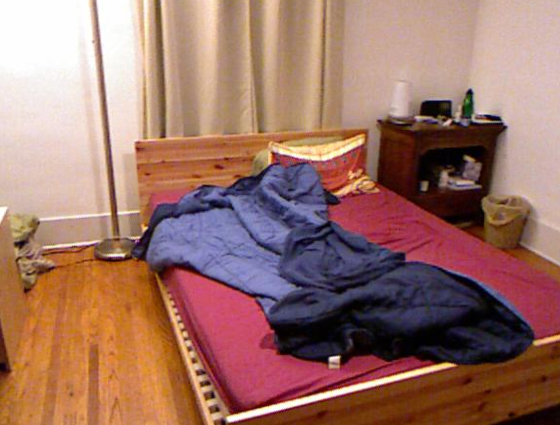

Question:	 what is the object on the floor in front of the cabinet
Answer:		 garbage_bin (Label: 236)
Predicted Answer:	 garbage_bin
*********************************************************
*********************************************************


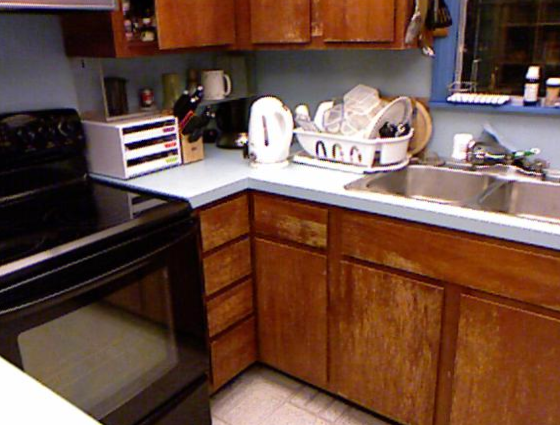

Question:	 what is beneath the stove
Answer:		 oven (Label: 355)
Predicted Answer:	 oven
*********************************************************
*********************************************************


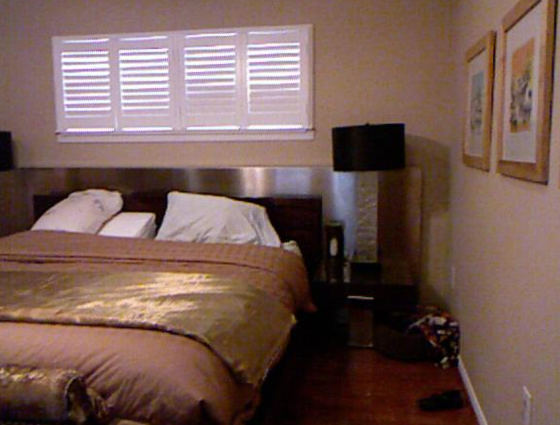

Question:	 what is on the night stand
Answer:		 lamp (Label: 308)
Predicted Answer:	 lamp
*********************************************************
*********************************************************


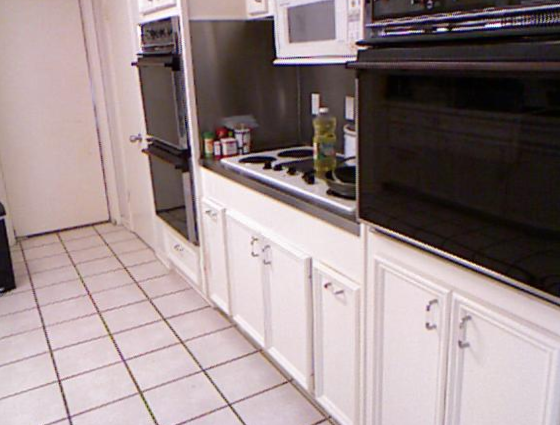

Question:	 what is on the above the stove
Answer:		 microwave (Label: 332)
Predicted Answer:	 microwave
*********************************************************
*********************************************************


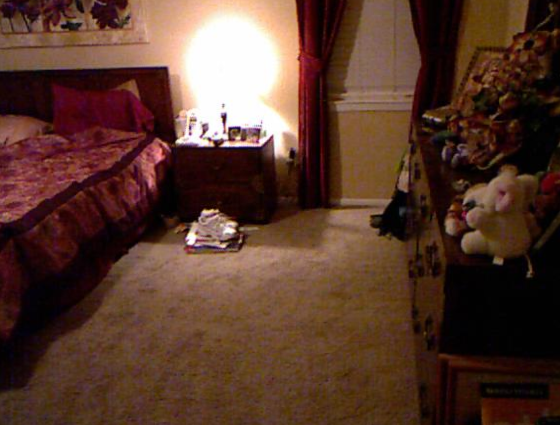

Question:	 what is on the wall
Answer:		 spot_light (Label: 462)
Predicted Answer:	 picture
*********************************************************


In [ ]:
for i in range(5, 10):
    print("*********************************************************")
    showExample(train=False, id=i)
    print("Predicted Answer:\t", answer_space[preds[i-5]])
    print("*********************************************************")

# Testing the model by uplodaing new images and questions

In [ ]:
class MultimodalVQAModel(nn.Module):
    def __init__(
            self,
            num_labels: int = len(answer_space),
            intermediate_dim: int = 512,
            pretrained_text_name: str = 'bert-base-uncased',
            pretrained_image_name: str = 'google/vit-base-patch16-224-in21k'):

        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name

        self.text_encoder = AutoModel.from_pretrained(
            self.pretrained_text_name,
        )
        self.image_encoder = AutoModel.from_pretrained(
            self.pretrained_image_name,
        )
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

        self.classifier = nn.Linear(intermediate_dim, self.num_labels)

        self.criterion = nn.CrossEntropyLoss()

    def forward(
            self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):

        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )
        logits = self.classifier(fused_output)

        out = {
            "logits": logits
        }
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss

        return out

In [ ]:
model=torch.load('/content/drive/MyDrive/dataset/vqa.pth')
model.eval()
model.to(device)

MultimodalVQAModel(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:

#preprocessor: AutoFeatureExtractor
preprocessor=AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_text(question):
        encoded_text = tokenizer(
            text=question,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'],
            "token_type_ids": encoded_text['token_type_ids'],
            "attention_mask": encoded_text['attention_mask'],
        }


def preprocess_images(path):
        processed_images = preprocessor(
            images=Image.open(path).convert('RGB'),
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'],
        }




sample=tokenize_text("what is in this picture")

image_pixel = preprocess_images("/content/drive/MyDrive/dataset/new_test/Nore-Floor-Lamp-floor-lamps-132632-hi-res-0.png")


input_ids = sample["input_ids"].to(device)
token_type_ids = sample["token_type_ids"].to(device)
attention_mask = sample["attention_mask"].to(device)


pixel_values = image_pixel["pixel_values"].to(device)




In [ ]:
output = model(input_ids, pixel_values, attention_mask, token_type_ids)

In [ ]:
preds = output["logits"].argmax(axis=-1).cpu().numpy()
preds

array([308])

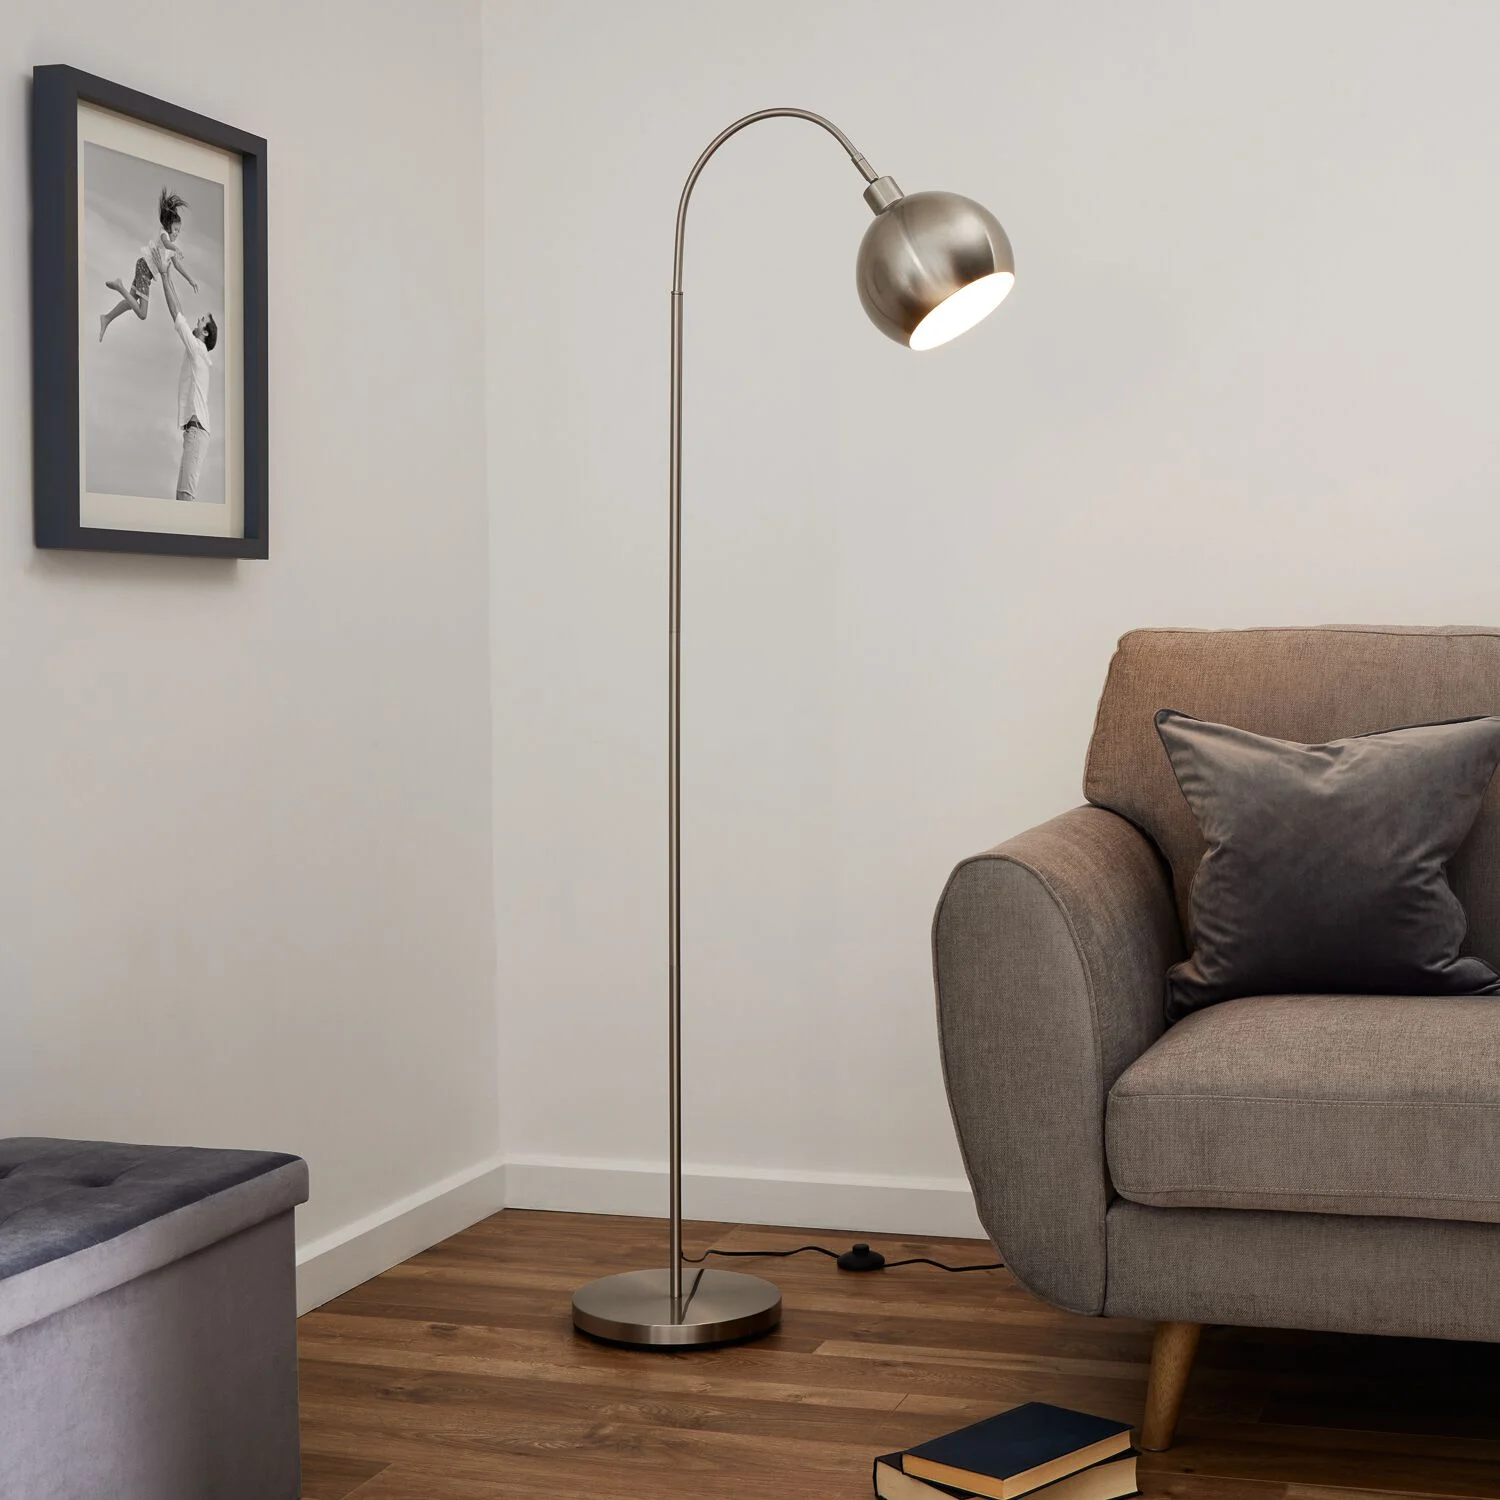

Predicted Answer:	 lamp


In [ ]:
from IPython.display import display

image = Image.open("/content/drive/MyDrive/dataset/new_test/Nore-Floor-Lamp-floor-lamps-132632-hi-res-0.png")
display(image)

print("Predicted Answer:\t", answer_space[preds[0]])